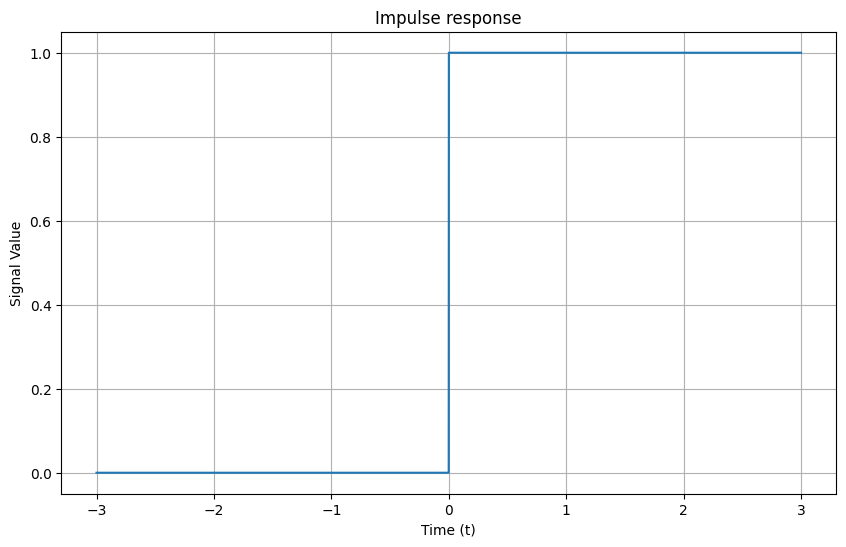

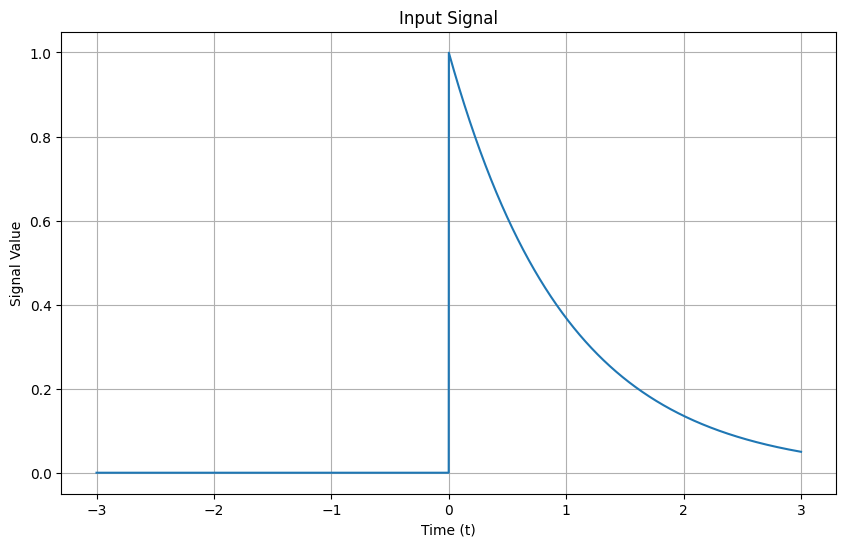

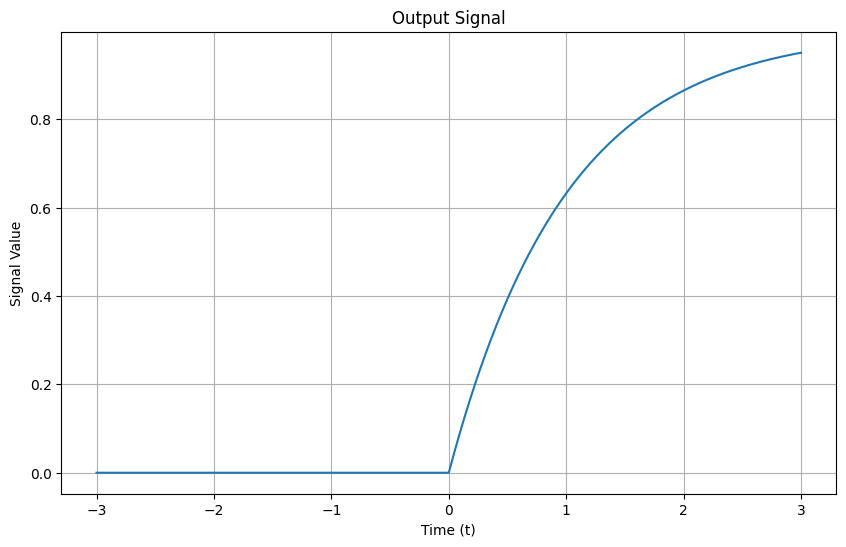

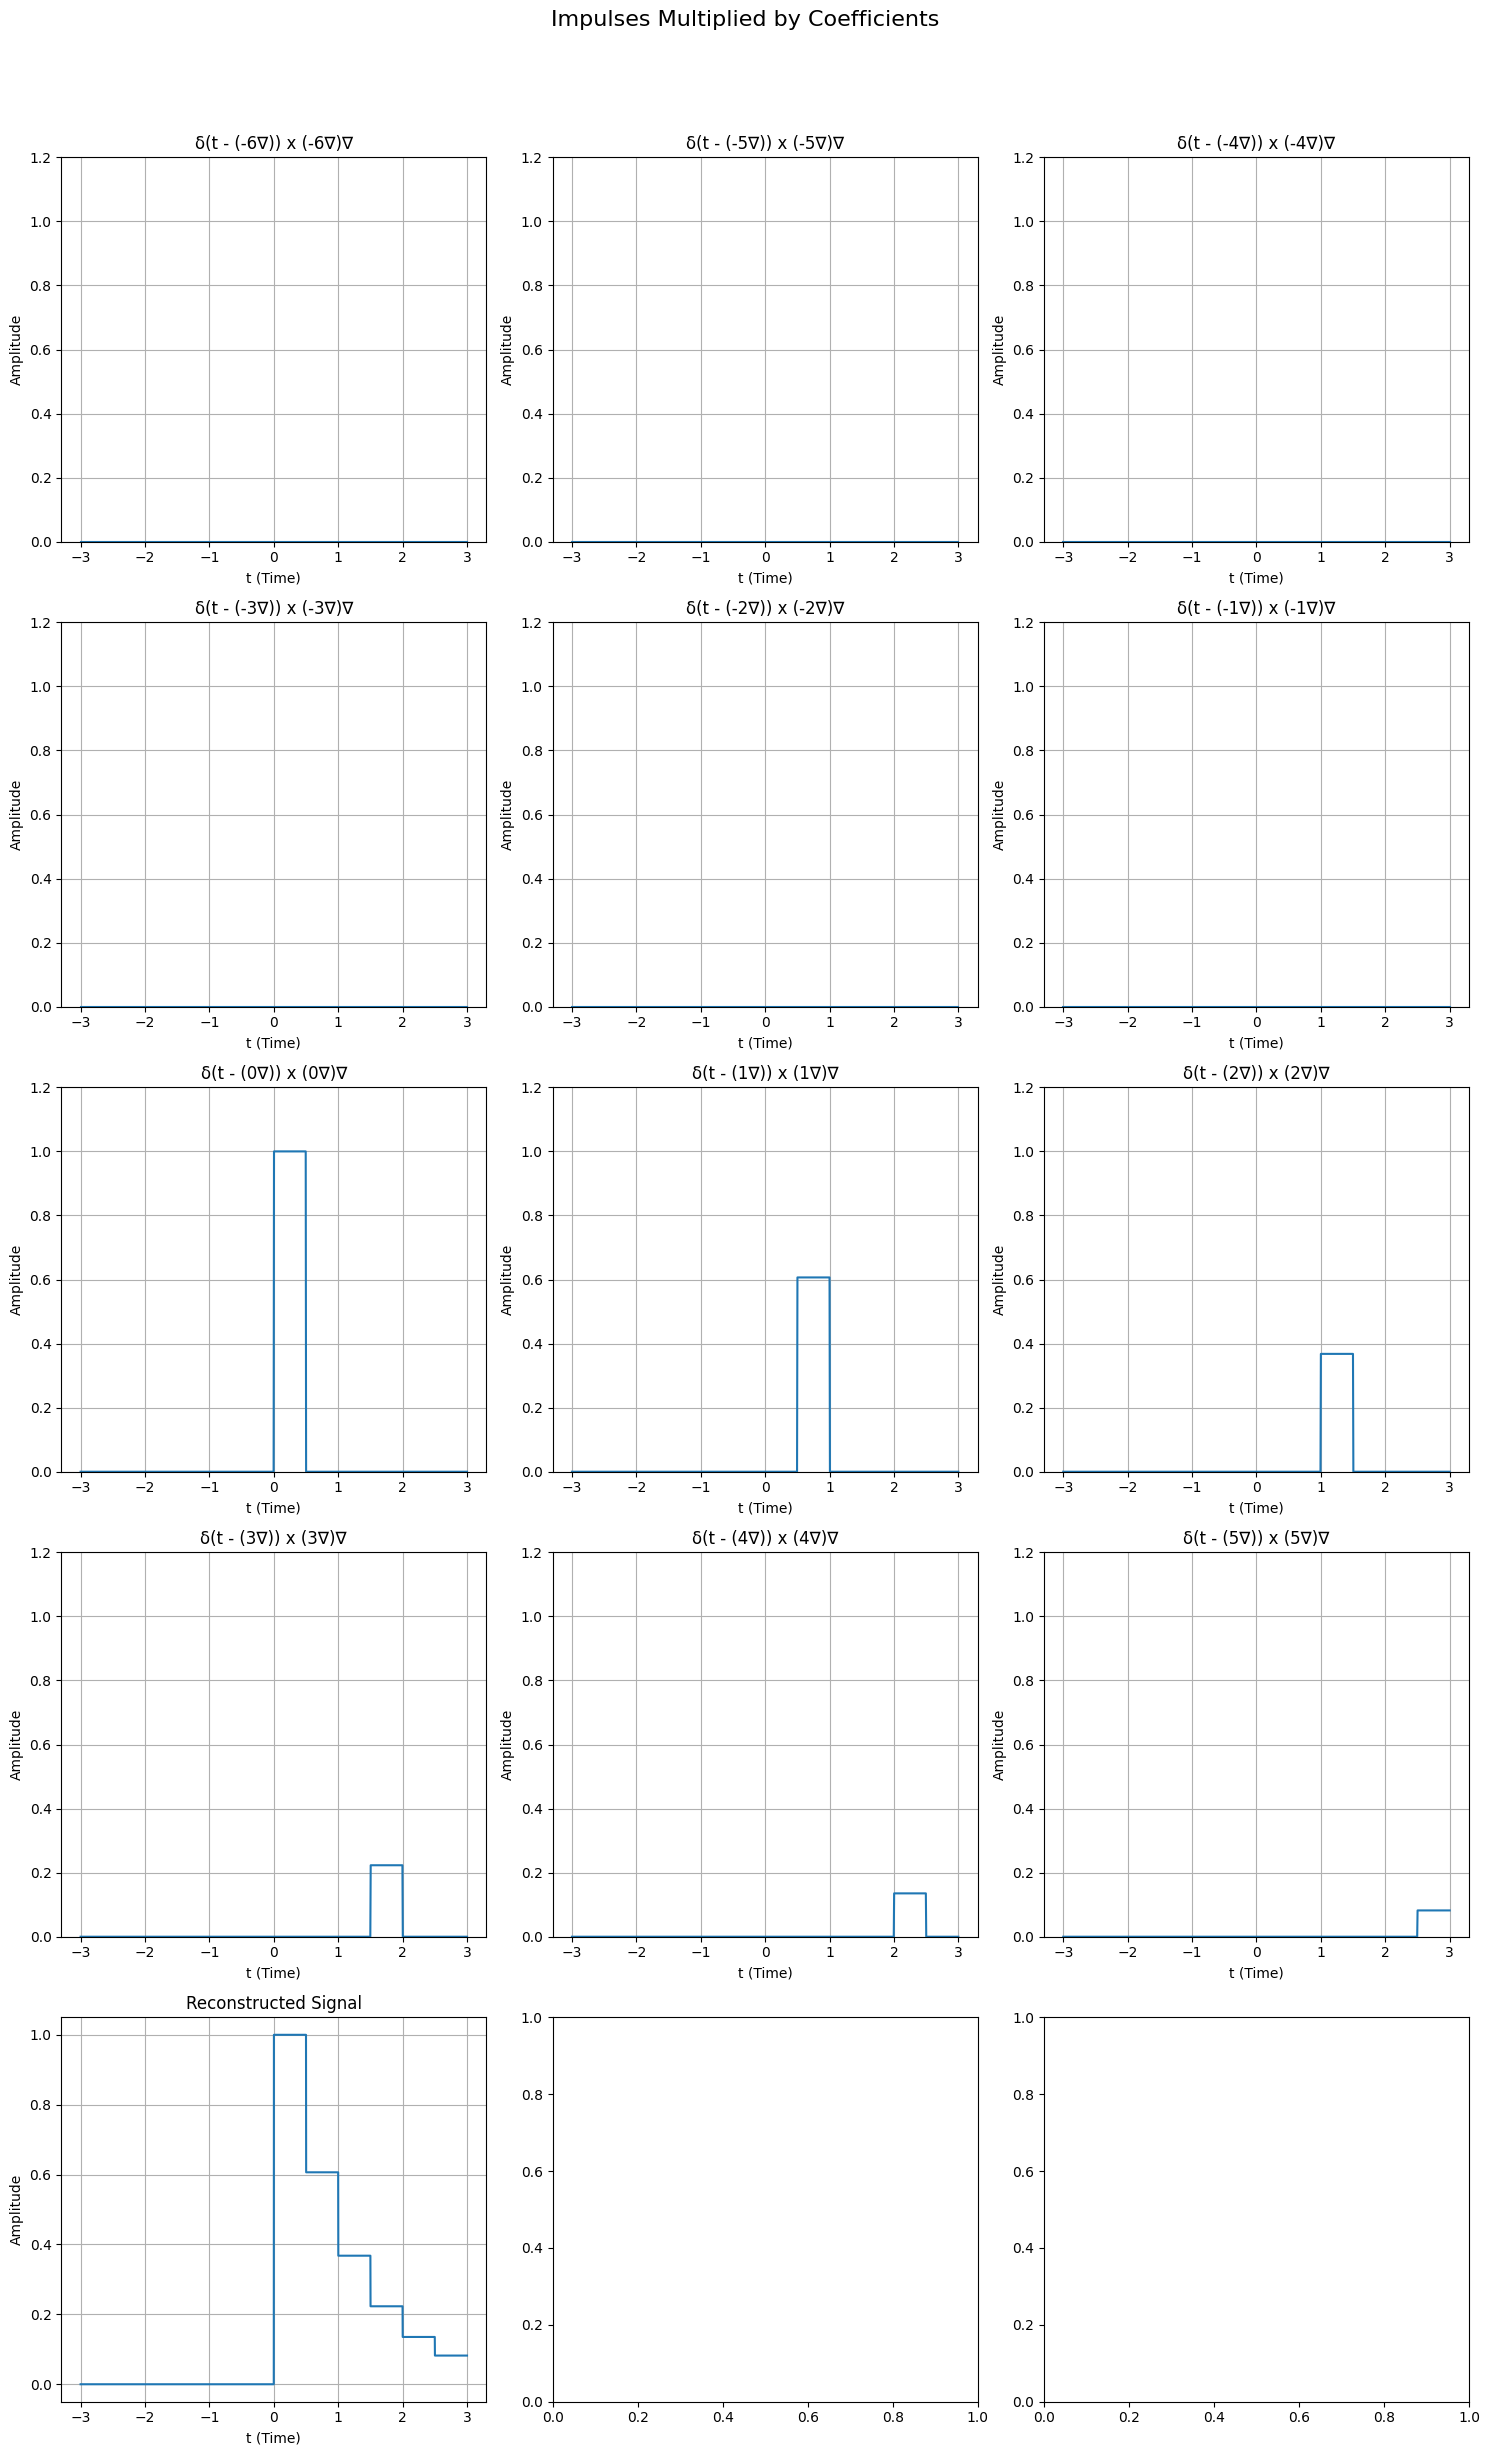

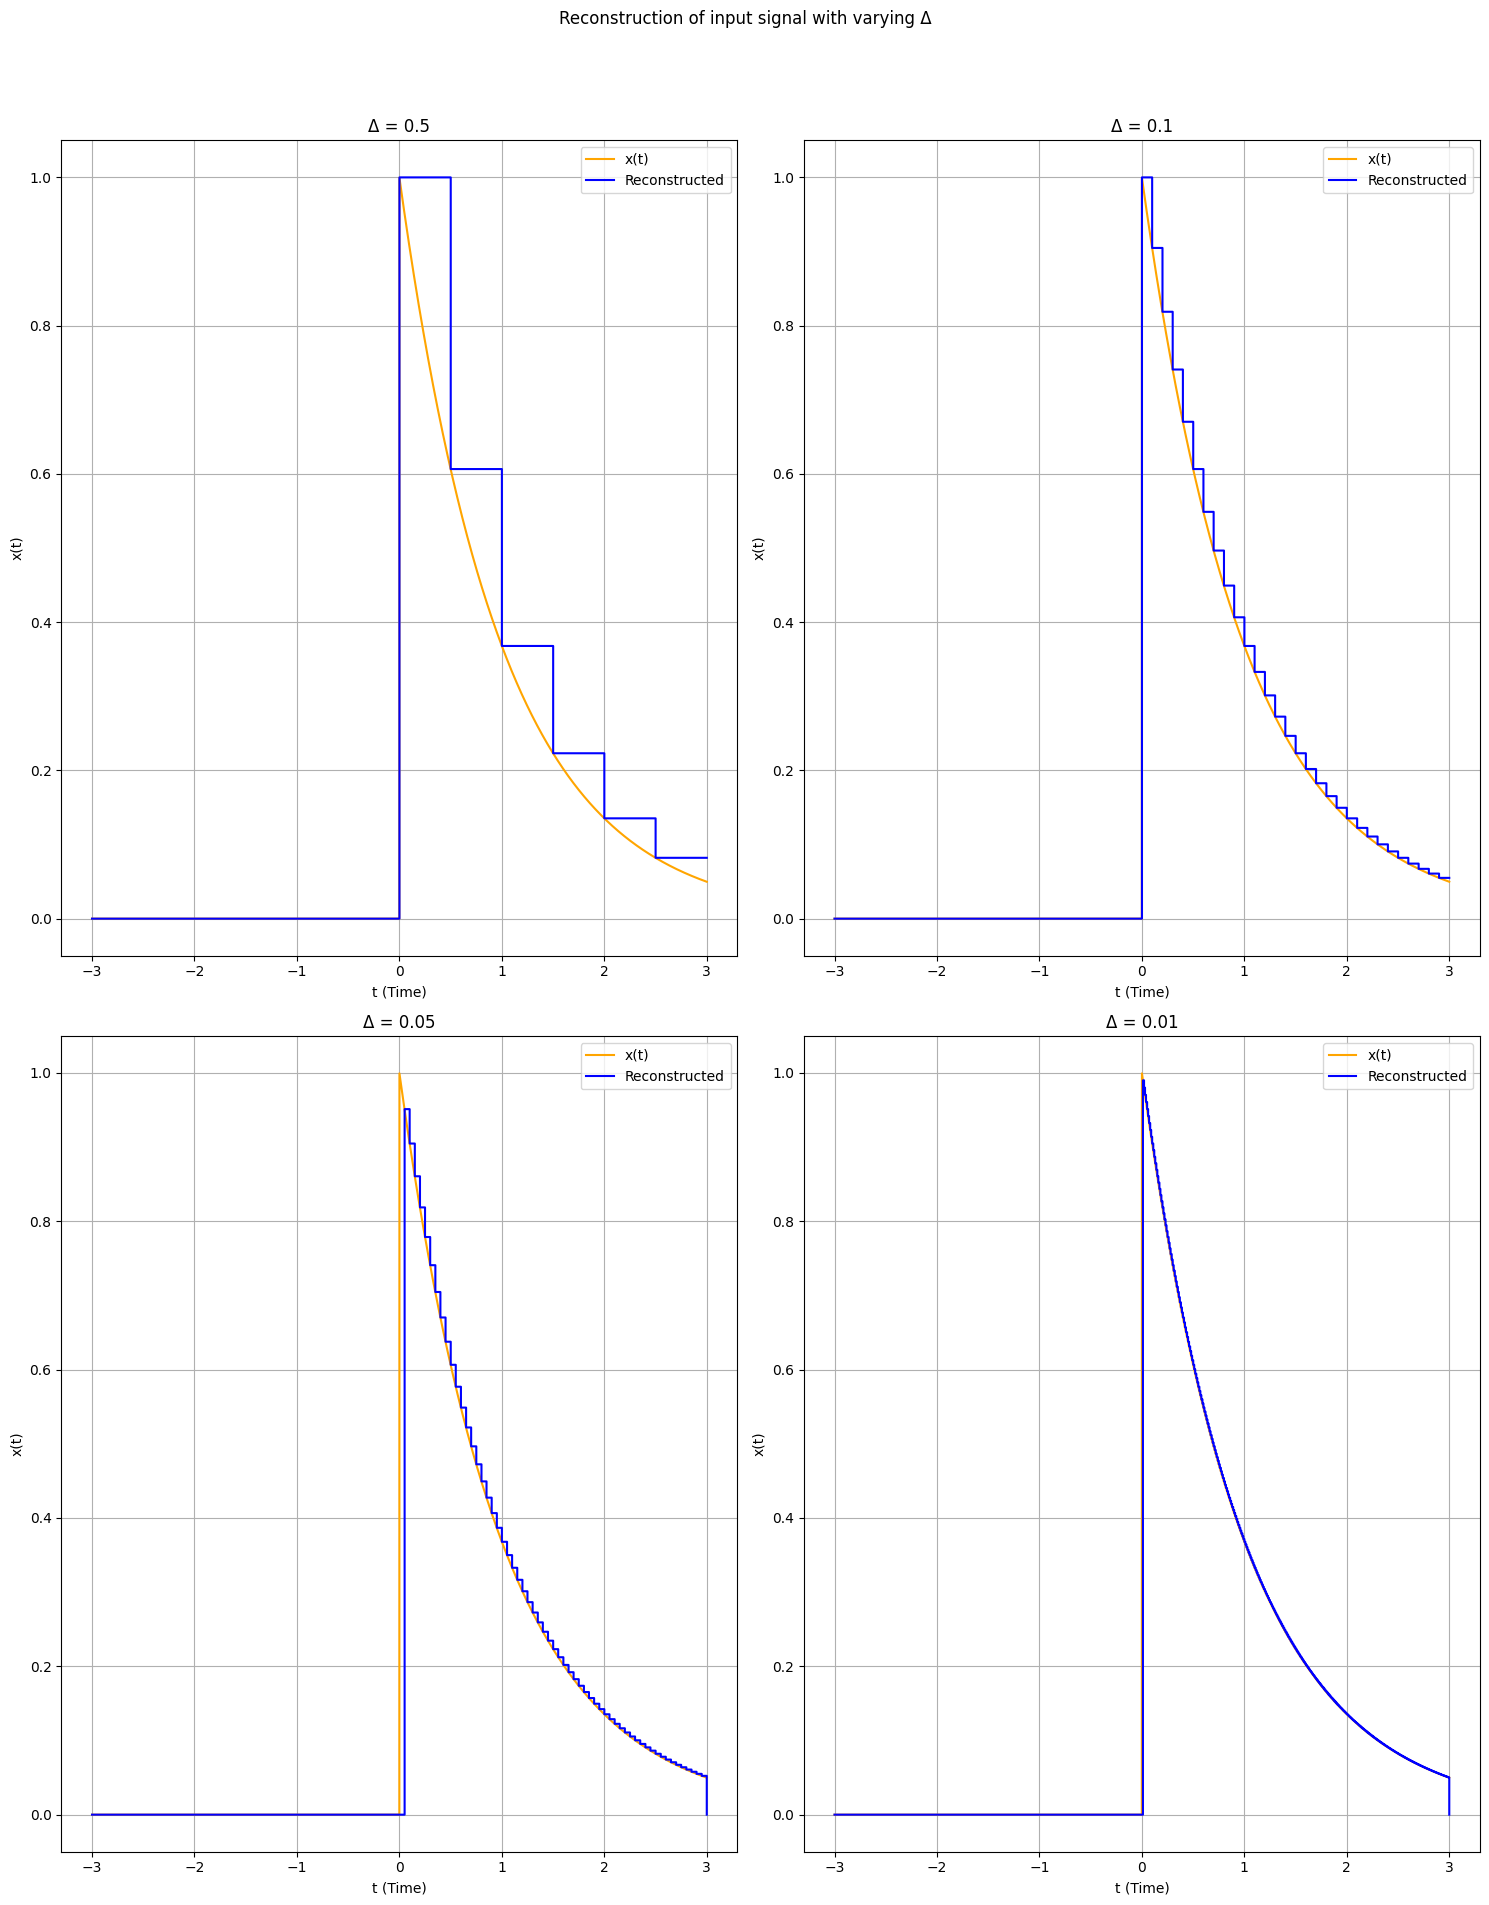

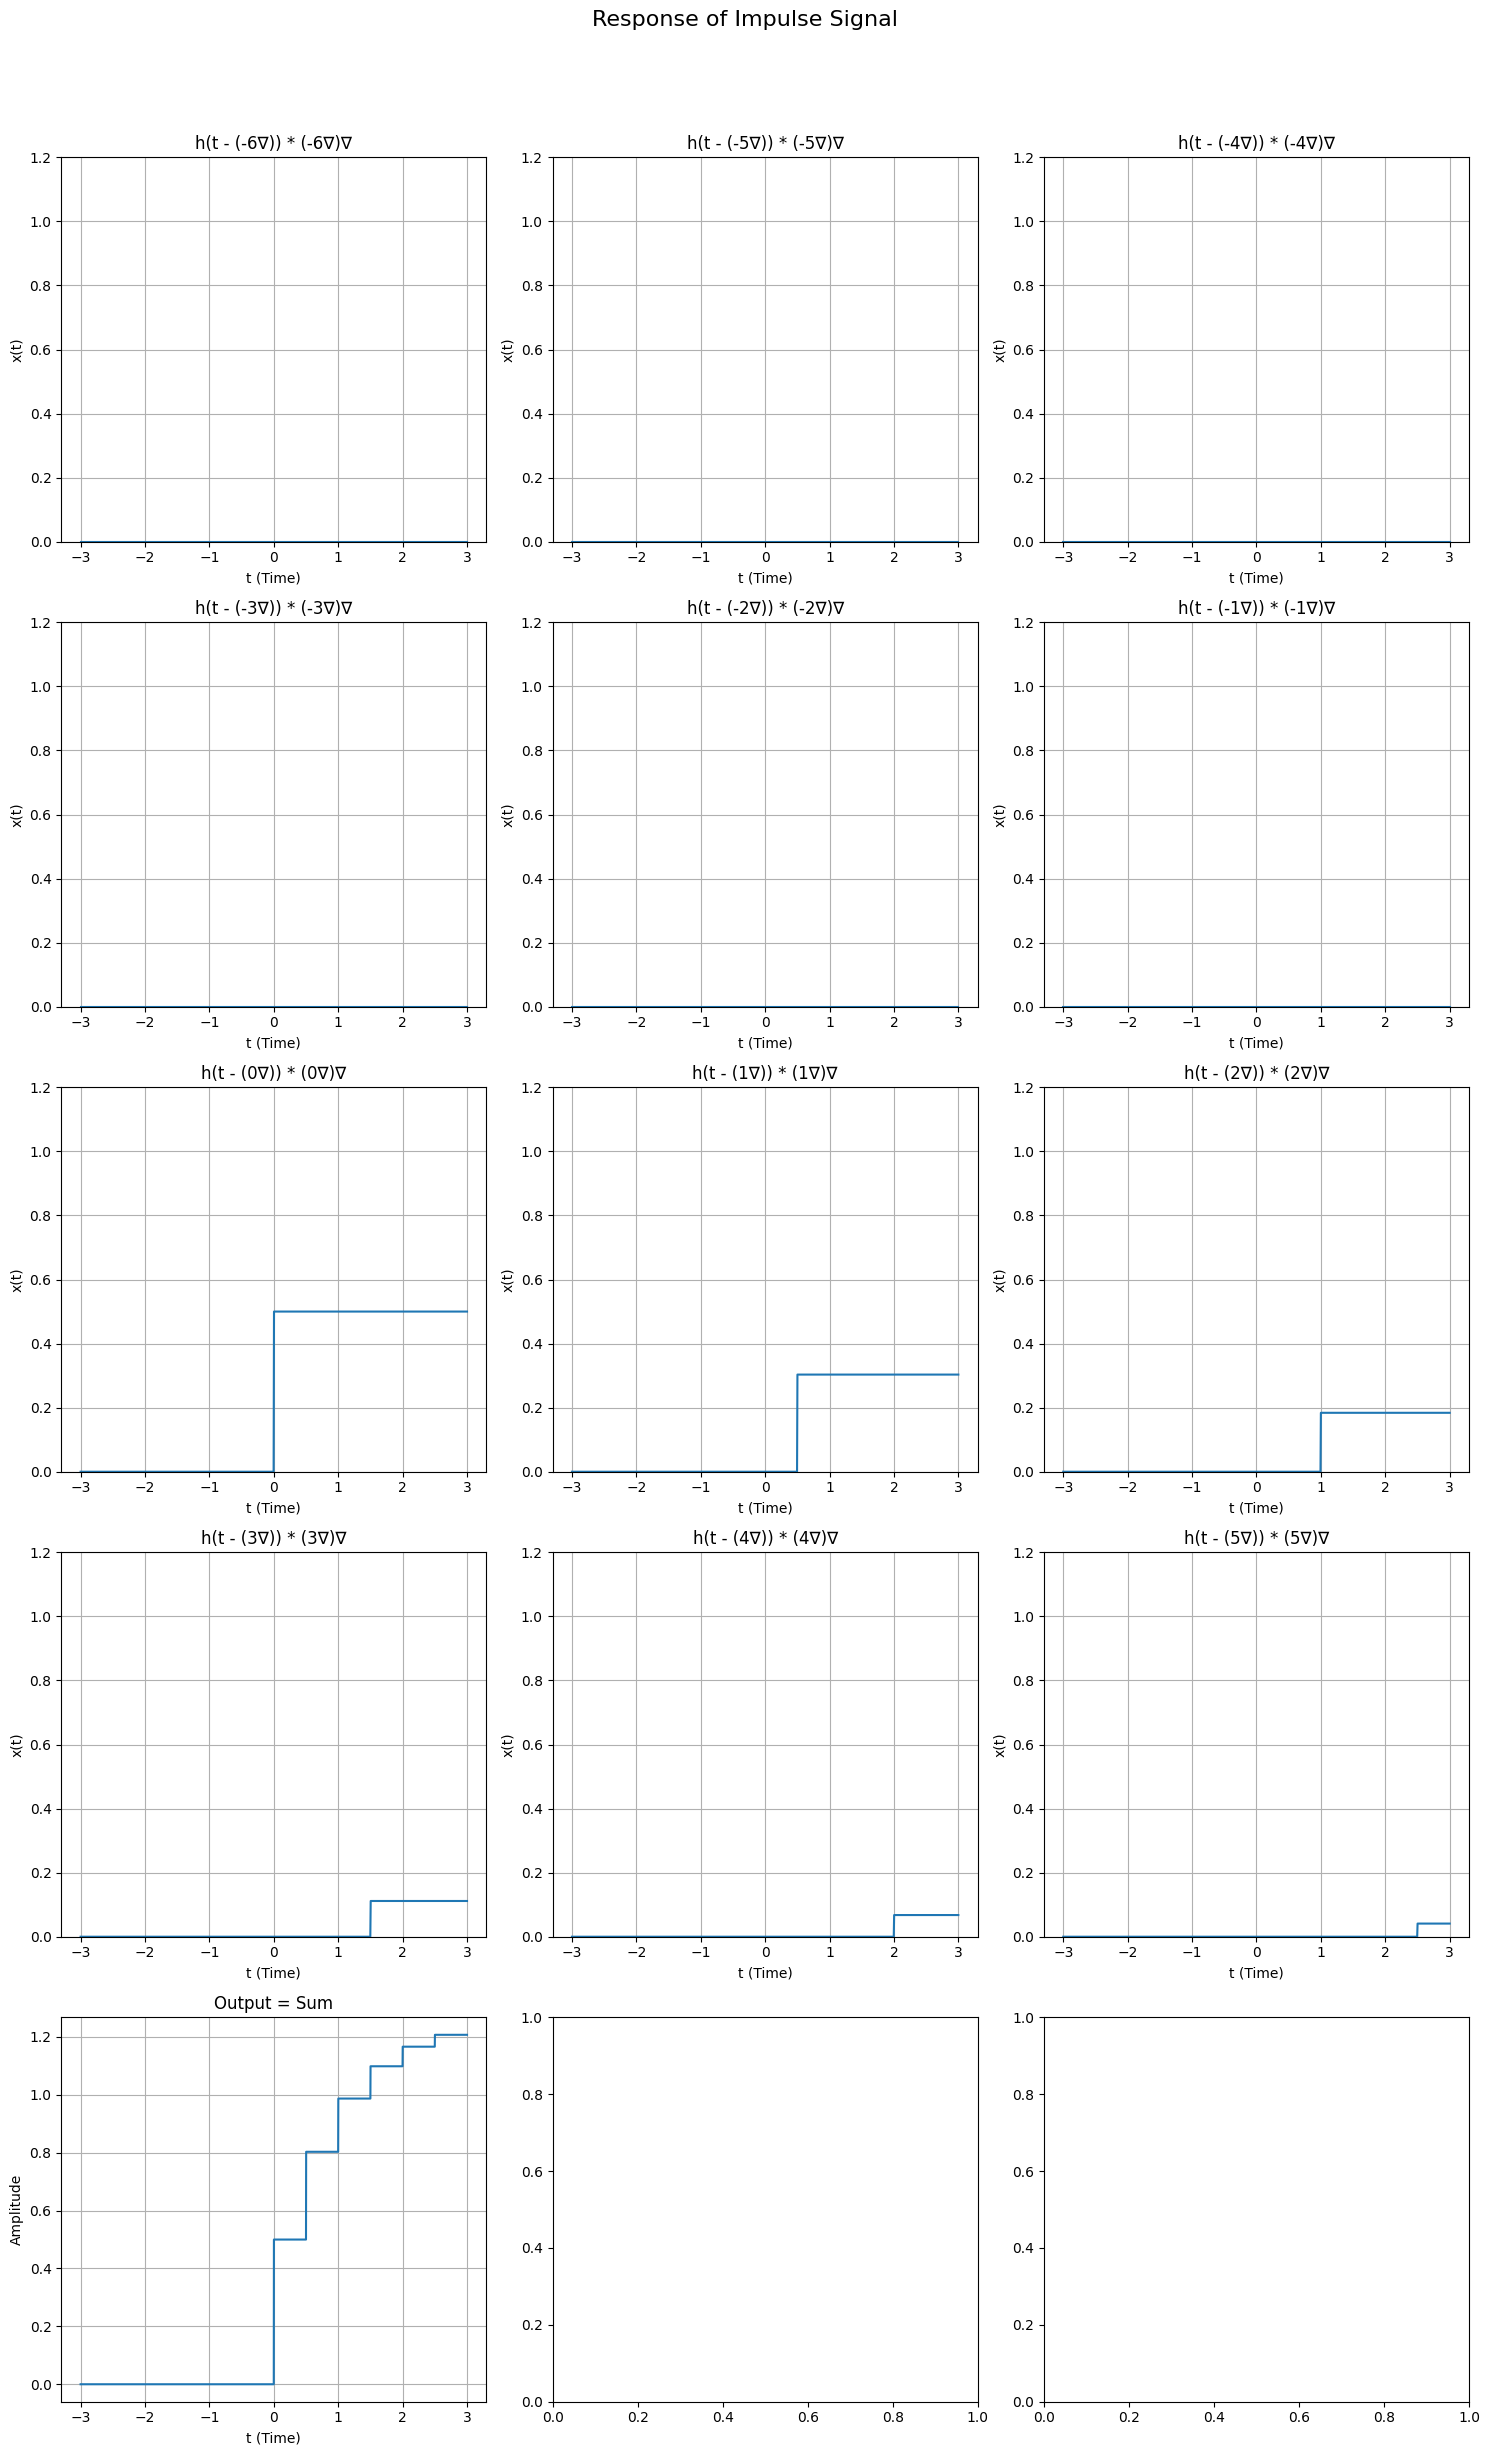

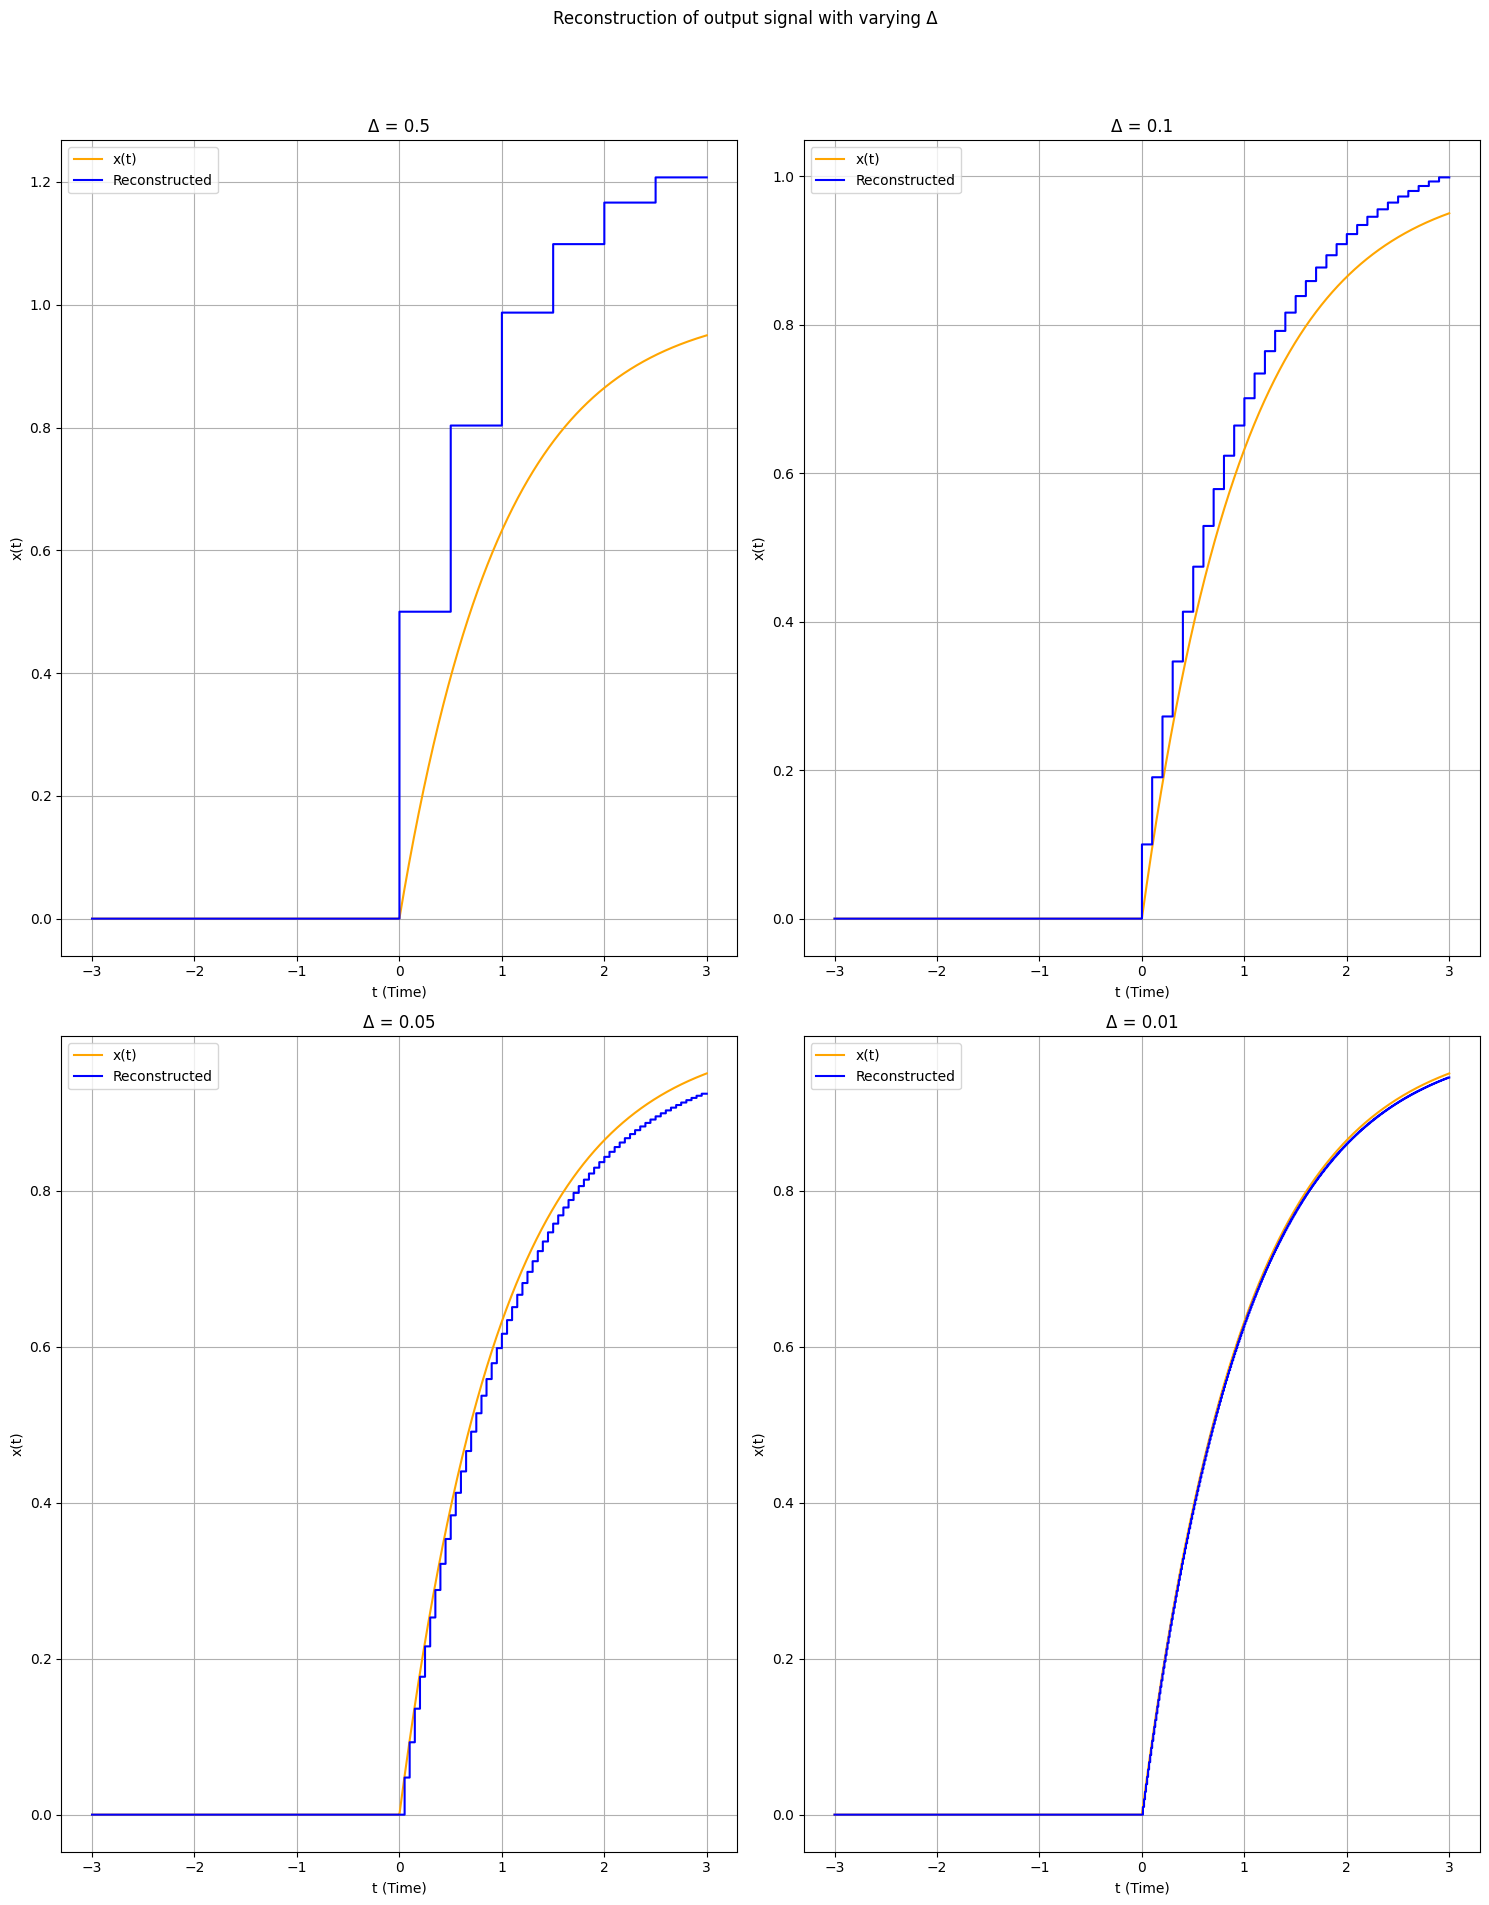

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os 

class ContinuousSignal:
    def __init__(self, func, INF):
        self.INF = INF
        self.func = func

    def shift(self, shift):
        shifted_func = lambda t: self.func(t - shift)
        return ContinuousSignal(shifted_func, self.INF)

    def add(self, other):
        added_func = lambda t: self.func(t) + other.func(t)
        return ContinuousSignal(added_func, self.INF)

    def multiply(self, other):
        multiplied_func = lambda t: self.func(t) * other.func(t)
        return ContinuousSignal(multiplied_func)

    def multiply_const_factor(self, scaler):
        scaled_func = lambda t: self.func(t) * scaler
        return ContinuousSignal(scaled_func, self.INF)

    def plot(self, title = "Continuous Signal"):
        save_path = "Continuous"
        os.makedirs(save_path, exist_ok=True)
        save_filepath = os.path.join(save_path, f"{title}.png")
        num_points = 5000 
        # t_range = [-self.INF, self.INF]
        t_values = np.linspace(-self.INF, self.INF, num_points)
        y_values = self.func(t_values)

        plt.figure(figsize=(10, 6))
        plt.plot(t_values, y_values)
        plt.title(title)
        plt.xlabel('Time (t)')
        plt.ylabel('Signal Value')
        plt.grid(True)
        plt.savefig(save_filepath, dpi=300)
        plt.show()

class LTIContinuous:
    def __init__(self, impulse_response):
        self.impulse_response = impulse_response

    def linear_combination_of_impulses(self, input_signal : "ContinuousSignal", delta : float):
        impulses = []
        # t_values = np.arange(-10, 10, delta)
        t_values = np.arange(-input_signal.INF, input_signal.INF, delta)
        coefficients = input_signal.func(t_values) * delta
        for t in t_values:
            # impulse = lambda tau: input_signal.func(tau) * self.impulse_response.func(t - tau)
            impulse = ContinuousSignal(lambda tau, t=t: (1 / delta) * ((t <= tau) & (tau <= t + delta)), input_signal.INF)
            impulses.append(impulse)
        return impulses, coefficients

    def output_approx(self, input_signal, delta):
        t_values = np.arange(-input_signal.INF, input_signal.INF, delta)
        constituent_impulses = []
        coeffcients = []
        output_signal = ContinuousSignal(lambda t: 0, input_signal.INF)

        for t in t_values:
            # impulse = ContinuousSignal(lambda tau: (1 / delta) * ((t <= tau) & (tau <= t + delta)), input_signal.INF)
            response = self.impulse_response.shift(t)
            constituent_impulses.append(response)
            coeffcients.append(input_signal.func(t) * delta)
            output_signal = output_signal.add(response.multiply_const_factor(input_signal.func(t) * delta))

        return constituent_impulses, coeffcients, output_signal
    
    def impulse_multiplied_by_coefficients_plot(self, input_signal, delta):
        #figure save 
        save_path = "Continuous"
        os.makedirs(save_path, exist_ok=True)
        save_filepath = os.path.join(save_path, "impulse_multiplied_by_coefficients_plot.png")


        impulses, coefficients = self.linear_combination_of_impulses(input_signal, delta)
        num_plots = len(impulses)
        rows = num_plots // 3 + 1
        cols = 3
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        fig.suptitle('Impulses Multiplied by Coefficients', fontsize=16)

    # reconstructed_signal == ContinuousSignal(lambda t: np.sum([coeff * imp.func(t) for imp, coeff in zip(impulses, coefficients)]), INF=3)
        reconstructed_signal = ContinuousSignal(lambda t : 0, input_signal.INF)
        
        # Iterate over each impulse and its coefficient to plot them in the grid
        for idx, (imp, coeff) in enumerate(zip(impulses, coefficients)):
            # Determine the row and column for the subplot
            row = idx // cols
            col = idx % cols
            new_signal = imp.multiply_const_factor(coeff)
            reconstructed_signal = reconstructed_signal.add(new_signal)
            t_values = np.linspace(-input_signal.INF, input_signal.INF, 1000)
            y_values = [new_signal.func(t) for t in t_values]
            
            # Plot the signal in the corresponding subplot
            ax = axes[row, col]
            ax.plot(t_values, y_values)
            ax.set_title(f'δ(t - ({idx - 6}∇)) x ({idx-6}∇)∇')  # Adjust title as needed
            ax.set_xlabel('t (Time)')
            ax.set_ylim(0.0, 1.2)
            ax.set_ylabel('Amplitude')
            ax.grid(True)

        final_plot_idx = num_plots
        final_row = final_plot_idx // cols
        final_col = final_plot_idx % cols
        # Plot the reconstructed signal
        t_values = np.linspace(-input_signal.INF, input_signal.INF, 5000)
        y_values = [reconstructed_signal.func(t) for t in t_values]
        ax = axes[final_row, final_col]
        ax.plot(t_values, y_values)
        ax.set_title('Reconstructed Signal')
        ax.set_xlabel('t (Time)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(save_filepath, dpi=300)
        plt.show()

    def reconstructed_plot(self, input_signal, deltas):
        save_path = "Continuous"
        os.makedirs(save_path, exist_ok=True)
        save_filepath = os.path.join(save_path, "reconstructed_plot.png")
        # impulses, coefficients = self.linear_combination_of_impulses(input_signal, delta)
        # reconstructed_signal = ContinuousSignal(lambda t: np.sum([coeff * imp.func(t) for imp, coeff in zip(impulses, coefficients)]), INF=input_signal.INF)
        fig,axs = plt.subplots(int(len(deltas)/2), 2, figsize=(15, 5 * len(deltas)))
        fig.suptitle("Reconstruction of input signal with varying Δ")

        for i,delta in enumerate(deltas):
            impulses, coefficients = self.linear_combination_of_impulses(input_signal, delta) 
            reconstructed_signal = ContinuousSignal(lambda t : 0, input_signal.INF)  
            for imp, coeff in zip(impulses, coefficients):
                new_signal = imp.multiply_const_factor(coeff)
                reconstructed_signal = reconstructed_signal.add(new_signal)
            t_values = np.linspace(-input_signal.INF, input_signal.INF, 5000)
            y_values_xt = [input_signal.func(t) for t in t_values]
            y_values_reconstructed = [reconstructed_signal.func(t) for t in t_values]
            row, col = divmod(i,2)
            axs[row, col].plot(t_values, y_values_xt, 'orange', label="x(t)")
            axs[row, col].step(t_values, y_values_reconstructed, 'b-', label="Reconstructed", where='post')
            axs[row, col].set_title(f"Δ = {delta}")
            axs[row, col].set_xlabel("t (Time)")
            axs[row, col].set_ylabel("x(t)")
            axs[row, col].legend()
            axs[row, col].grid()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(save_filepath, dpi=300)
        plt.show()

    def response_of_impulse_plot(self, impulse_response,input_signal, delta):
        save_path = "Continuous"
        os.makedirs(save_path, exist_ok=True)
        save_filepath = os.path.join(save_path, "response_of_impulse_plot.png")
        # return impulse.multiply(self.impulse_response)]
        constituent_impulses, coefficients, output_signal = self.output_approx(input_signal, delta)
        num_plots = len(constituent_impulses)
        rows = num_plots // 3 + 1
        cols = 3
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        fig.suptitle('Response of Impulse Signal', fontsize=16)
        sum_signal = ContinuousSignal(lambda t : 0, input_signal.INF)
        for idx, (imp, coeff) in enumerate(zip(constituent_impulses, coefficients)):
            row = idx // cols
            col = idx % cols
            new_signal = imp.multiply_const_factor(coeff)
            sum_signal = sum_signal.add(new_signal)
            t_values = np.linspace(-input_signal.INF, input_signal.INF, 1000)
            y_values = [new_signal.func(t) for t in t_values]
            ax = axes[row, col]
            ax.plot(t_values, y_values)
            ax.set_title(f'h(t - ({idx - 6}∇)) * ({idx-6}∇)∇')
            ax.set_xlabel('t (Time)')
            ax.set_ylim(0.0, 1.2)
            ax.set_ylabel('x(t)')
            ax.grid(True)
        final_plot_idx = num_plots
        final_row = final_plot_idx // cols
        final_col = final_plot_idx % cols
        t_values = np.linspace(-input_signal.INF, input_signal.INF, 5000)
        y_values = [sum_signal.func(t) for t in t_values]
        ax = axes[final_row, final_col]
        ax.plot(t_values, y_values)
        ax.set_title('Output = Sum')
        ax.set_xlabel('t (Time)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(save_filepath, dpi=300)
        plt.show()
        # self.reconstructed_plot(output_signal, [0.5, 0.1, 0.05,0.01])




        # for imp, coeff in zip(constituent_impulses, coefficients):
        #     print(coeff)
        #     imp.plot("before")
        #     new_signal = imp.multiply_const_factor(coeff)
        #     new_signal.plot("after")
        #     # t_values = np.linspace(-imp.INF, imp.INF, 5000)
        #     # y_values = [new_signal.func(t) for t in t_values]
        #     # plt.plot(t_values, y_values)
        #     # plt.title(f'δ(t - ({idx - 6}∇)) x ({idx-6}∇)∇')

#Reconstructed output plot 

    def reconstructed_output_plot(self, input_signal,actual_output_signal, deltas):
        save_path = "Continuous"
        os.makedirs(save_path, exist_ok=True)
        save_filepath = os.path.join(save_path, "reconstructed_output_plot.png")

        # impulses, coefficients = self.linear_combination_of_impulses(input_signal, delta)
        # reconstructed_signal = ContinuousSignal(lambda t: np.sum([coeff * imp.func(t) for imp, coeff in zip(impulses, coefficients)]), INF=input_signal.INF)
        # constituent_impulses, coefficients, output_signal = self.output_approx(input_signal, delta)
        fig,axs = plt.subplots(int(len(deltas)/2), 2, figsize=(15, 5 * len(deltas)))
        fig.suptitle("Reconstruction of output signal with varying Δ")

        for i,delta in enumerate(deltas):
            # impulses, coefficients = self.linear_combination_of_impulses(output_signal, delta) 
            constituent_impulses, coefficients, output_signal = self.output_approx(input_signal, delta)
            reconstructed_signal = ContinuousSignal(lambda t : 0, output_signal.INF)  
            t_values = np.linspace(-output_signal.INF, output_signal.INF, 5000)
            y_values_xt = [actual_output_signal.func(t) for t in t_values]
            y_values_reconstructed = [output_signal.func(t) for t in t_values]
            row, col = divmod(i,2)
            axs[row, col].plot(t_values, y_values_xt, 'orange', label="x(t)")
            axs[row, col].step(t_values, y_values_reconstructed, 'b-', label="Reconstructed", where='post')
            axs[row, col].set_title(f"Δ = {delta}")
            axs[row, col].set_xlabel("t (Time)")
            axs[row, col].set_ylabel("x(t)")
            axs[row, col].legend()
            axs[row, col].grid()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(save_filepath, dpi=300)
        plt.show()




        

        


def main():
    # Define a continuous signal
    # def func(t):
    #     return np.sin(t)

    # signal = ContinuousSignal(func)
    # signal.plot()

    # # Shift the signal
    # shifted_signal = signal.shift(2)
    # shifted_signal.plot()

    # # Add two signals
    # added_signal = signal.add(shifted_signal)
    # added_signal.plot()

    # # Multiply two signals
    # multiplied_signal = signal.multiply(shifted_signal)
    # multiplied_signal.plot()

    # # Multiply the signal by a constant factor
    # scaled_signal = signal.multiply_const_factor(2)
    # scaled_signal.plot()
    # impulse_response_func = lambda t : 1 * (t >= 0)
    # impulse_response = ContinuousSignal(impulse_response_func, INF=3)
    # impulse_response.plot()

    # lti_system = LTIContinuous(impulse_response)
        # Define an example impulse response (e.g., exponential decay)
    impulse_response_func = lambda t: 1 * (t >= 0)
    impulse_response = ContinuousSignal(impulse_response_func, INF=3)
    impulse_response.plot("Impulse response")

    # Create an LTI Continuous system
    lti_system = LTIContinuous(impulse_response)

    # Define an example input signal (e.g., sine wave)
    input_signal_func = lambda t: np.exp(-t) * (t >= 0)
    input_signal = ContinuousSignal(input_signal_func, INF=3)
    input_signal.plot("Input Signal")

    # # Define an output signal
    # t = np.linspace(-5, 5, 500)
    # output_signal_func = np.piecewise(t, [t < 0, t >= 0], [0, lambda t: 1 - np.exp(-t)])
    output_signal_func = lambda t: (1 - np.exp(-t)) * (t >= 0)
    output_signal = ContinuousSignal(output_signal_func, INF=3)
    output_signal.plot("Output Signal")


    lti_system.impulse_multiplied_by_coefficients_plot(input_signal, 0.5)

    Deltas = [0.5, 0.1, 0.05,0.01]
    lti_system.reconstructed_plot(input_signal, Deltas)
    lti_system.response_of_impulse_plot(impulse_response,input_signal, 0.5)
    lti_system.reconstructed_output_plot(input_signal,output_signal, Deltas)

    # lti_system.impulse_multiplied_by_coefficients_plot(impulse_response, 0.5)
        


if __name__ == '__main__':
        main()
